In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy, torch
from torch import nn,optim
plt.rcParams.update({'font.size': 14})
figure_folder = 'WH-figures/'

#follow the intruction in deepSI on github to install our preliminary toolbox
import deepSI

## Load Wiener-Hammerstein (WH) data

see: https://sites.google.com/view/nonlinear-benchmark/benchmarks/wiener-hammerstein?authuser=0

train = System_data of length: 100000 nu=None ny=None normed=False dt=None (100000,) (100000,)
test = System_data of length: 78800 nu=None ny=None normed=False dt=None (78800,) (78800,)


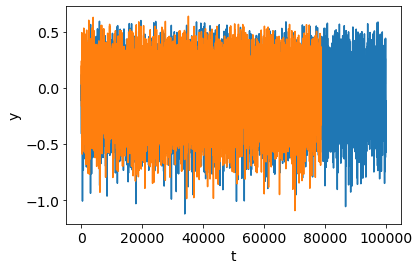

In [2]:
train, test = deepSI.datasets.WienerHammerBenchMark(split_data=True) #will download the dataset into C:/Users/user/AppData/Local/deepSI/data_sets
print('train =',train, train.y.shape, train.u.shape) #training and validation is combined into one training set
print('test =',test, test.y.shape, test.u.shape)
train.plot()
test.plot(show=True)

## Fit/load state-space encoder model

To note; this takes a over 200 hours to converge to the final result which can be viewed in the paper. You can stop the optimization early by using `KeyboardInterrupt` (Ctrl-C or kernel interrupt) which uses early stopping.

In [4]:
if True: #train model
    sys = deepSI.fit_systems.SS_encoder(nx=6,na=50,nb=50) #load the encoder system
    sys.n_hidden_layers = 1
    sys.n_nodes_per_layer = 15
    sys.fit(train, val_sys_data=train[-20000:], epochs=100_000, batch_size=1024, loss_kwargs=dict(nf=80)) #can be stopped early with keyboard
    #nf = number of steps in each encoder mutiple schooting section (T in the paper)
    sys.save_system('./WH-data/nx6WH-encoder')
    sim_val = train[-40_000:] #larger validation set
    sys.bestfit = sys.apply_experiment(sim_val).NRMS(sim_val) #reset checkpoint
    #use all the data for final local minima search
    sys.fit(train,sim_val, epochs=500 ,batch_size=10**10, loss_kwargs=dict(nf=80)) 
    sys.save_system('./WH-data/nx6WH-encoder-stepped')
else: #load model from file
    sys = deepSI.load_system('./WH-data/nx6WH-encoder-stepped')

## Fit/load BLA model

In [5]:
if True: #train model
    sys_BLA = deepSI.fit_systems.SS_linear(nx=6) 
    sys_BLA.fit(train) #uses N4SID method, SS_f=20 (code used from https://github.com/CPCLAB-UNIPI/SIPPY/blob/master/sippy/OLSims_methods.py)
    sys_BLA.save_system('./WH-data/nx6WH-BLA')
else: #load model from file
    sys_BLA = deepSI.load_system('./WH-data/nx6WH-BLA')

## Calculate test RMS/NRMS simulation

 * NRMS = RMS/$\sigma_y$

In [6]:
test_encoder_sim = sys.apply_experiment(test) #simulation
train_encoder_sim = sys.apply_experiment(train) #simulation

In [7]:
print('Test set result:')
print(f'   NRMS test  encoder {test_encoder_sim.NRMS(test):.5%} ')
print(f'    RMS test  encoder {test_encoder_sim.RMS(test)*1000:.5} mV')
print('\nTrain set result:')
print(f'   NRMS train encoder {train_encoder_sim.NRMS(train):.5%} ')
print(f'    RMS train encoder {train_encoder_sim.RMS(train)*1000:.5} mV')
print('\nsigma_y =',np.mean(test.y**2)**0.5)

Test set result:
   NRMS test  encoder 10.00293% 
    RMS test  encoder 24.393 mV

Train set result:
   NRMS train encoder 10.05573% 
    RMS train encoder 24.596 mV

sigma_y = 0.24715164906136317


## Error analysis
### Time domain

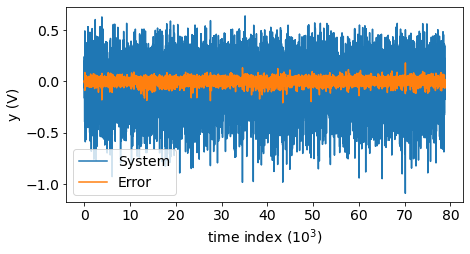

In [8]:
plt.figure(figsize=(9*0.75,5*0.75))
time = np.arange(len(test_encoder_sim))/1000
plt.plot(time,test.y)
plt.plot(time,test.y-test_encoder_sim.y)
plt.legend(['System','Error'])
plt.xlabel('time index ($10^3$)')
plt.ylabel('y (V)')
plt.tight_layout()
plt.savefig(figure_folder+'error-time.pdf')
plt.savefig(figure_folder+'error-time.png',dpi=200)
plt.show()

### Frequency/Fourier domain

#### Load other models

In [9]:
test_BLA_sim = sys_BLA.apply_experiment(test) #simulation
print('BLA test simulation result:')
print(f'  NRMS {test_BLA_sim.NRMS(test):.5%}') #don't know why it is lower than BLA from Lauwers et al 2009. 
print(f'   RMS {test_BLA_sim.RMS(test)*1000:.6}') #don't know why it is lower than BLA from Lauwers et al 2009. 

y_test_NLLFR_res = scipy.io.loadmat('./WH-data/yval-matlab-NL-LFR.mat')['yValSSNNdiff'][:,0] #residual of the NLLFR model
print('\nNLLFR simulation test result:')
print(f'  NRMS {np.mean(y_test_NLLFR_res**2)**0.5/np.std(test.y):.5%}') 
print(f'   RMS {np.mean(y_test_NLLFR_res**2)**0.5*1000:.5}') 

BLA test simulation result:
  NRMS 18.20754%
   RMS 44.4004

NLLFR simulation test result:
  NRMS 0.12059%
   RMS 0.29408


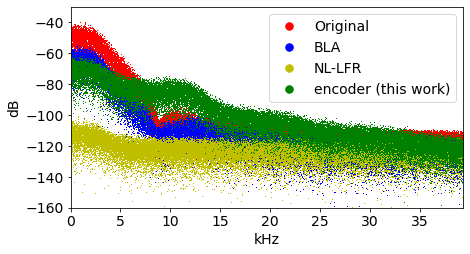

In [10]:
from scipy import fftpack


#two utility function
db = lambda a: 20*np.log10(np.abs(fftpack.fft(a)/len(a))) #convert ot db
Hz = lambda x: np.arange(len(x))/1000 #rescale to kHz
n_skip = 150 #skip transient


#
plt.figure(figsize=(9*0.75,5*0.75))
#original:
ydb = db(test.y[n_skip:]) 
plt.plot(Hz(ydb),ydb,'r,')
#BLA:
ydb = db(test.y[n_skip:]-test_BLA_sim.y[n_skip:]) 
plt.plot(Hz(ydb),ydb,'b,')
#NL-LFR:
ydb = db(y_test_NLLFR_res)
plt.plot(Hz(ydb),ydb,'y,')
#ss-encoder:
ydb = db(test.y[n_skip:]-test_encoder_sim.y[n_skip:])
plt.plot(Hz(ydb),ydb,'g,')

#manual creation of legend (markers dont with with , as marker)
import matplotlib.patches as mpatches
import matplotlib.lines as mlines 
red_line = mlines.Line2D([], [], color='r', marker='.',
                          markersize=15, label='Original',linestyle='None')
blue_line = mlines.Line2D([], [], color='b', marker='.',
                          markersize=15, label='BLA',linestyle='None')
yellow_line = mlines.Line2D([], [], color='y', marker='.',
                          markersize=15, label='NL-LFR',linestyle='None')
green_line = mlines.Line2D([], [], color='g', marker='.',
                          markersize=15, label='encoder (this work)',linestyle='None')
plt.legend(handles=[red_line,blue_line,yellow_line,green_line],loc='upper right')

plt.xlim(0,(len(test)//2-n_skip//2)/1000)
plt.ylabel('dB')
plt.xlabel('kHz')
plt.ylim(-160,-30)
plt.tight_layout()
plt.savefig(figure_folder+'fft.png',dpi=115)
plt.show()

## Training curve figure

### Get other modes of operations 

In [11]:
#timings excluding 
#encoder 7.77s/epoch
#no encoder = simulation loss 42.86s/it
#no batch 3.87s/it

In [12]:
if True: #train model
    sys_no_encode = deepSI.fit_systems.SS_encoder(nx=6,na=1,nb=1) #encoder is used ones to initialize one state, same as parametric start
    sys_no_encode.n_hidden_layers = 1
    sys_no_encode.n_nodes_per_layer = 15
    sys_no_encode.fit(train,train[-20000:],epochs=15184,batch_size=1,loss_kwargs=dict(nf=len(train)-sys_no_encode.na))
    sys_no_encode.save_system('./WH-data/nx6WH-non-encoder')
else: #load model from file
    sys_no_encode = deepSI.load_system('./WH-data/nx6WH-non-encoder')
    
if True: #train model
    sys_no_batch = deepSI.fit_systems.SS_encoder(nx=6,na=50,nb=50) #encoder is used ones to initialize one state, same as parametric start
    sys_no_batch.n_hidden_layers = 1
    sys_no_batch.n_nodes_per_layer = 15
    sys_no_batch.fit(train,train[-20000:],epochs=10000,batch_size=99901,loss_kwargs=dict(nf=80)) #small validation otherwise computation speed is lowered by a lot
    sys_no_batch.save_system('./WH-data/nx6WH-no-batch')
else: #load model from file
    sys_no_batch = deepSI.load_system('./WH-data/nx6WH-no-batch')

Size of the training array =  1.5 MB
N_training_samples = 1, batch_size = 1, N_batch_updates_per_epoch = 1
Initial Validation NRMS= 1.0506367267521644


  0%|          | 0/15184 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 1.0290926244202427
Epoch    1, sqrt loss   1.056, Val NRMS  1.029, Time Loss: 93.3%, data: 0.0%, val: 6.7%, 51.4 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.0125742324061093
Epoch    2, sqrt loss   1.032, Val NRMS  1.013, Time Loss: 93.1%, data: 0.0%, val: 6.9%, 49.9 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.003304277167146
Epoch    3, sqrt loss   1.014, Val NRMS  1.003, Time Loss: 93.4%, data: 0.0%, val: 6.6%, 52.1 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.0032424819959875
Epoch    4, sqrt loss   1.004, Val NRMS  1.003, Time Loss: 93.3%, data: 0.0%, val: 6.7%, 51.5 sec/batch
Epoch    5, sqrt loss   1.003, Val NRMS  1.006, Time Loss: 93.3%, data: 0.0%, val: 6.7%, 51.1 sec/batch
Epoch    6, sqrt loss   1.006, Val NRMS  1.007, Time Loss: 93.2%, data: 0.0%, val: 6.8%, 50.8 sec/batch
Stopping early due to a KeyboardInter

  0%|          | 0/10000 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### NRMS = 1.090103145054645
Epoch    1, sqrt loss   1.174, Val NRMS   1.09, Time Loss: 95.7%, data: 0.2%, val: 4.1%, 18.5 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.0701725149022419
Epoch    2, sqrt loss   1.132, Val NRMS   1.07, Time Loss: 95.6%, data: 0.2%, val: 4.2%, 18.5 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.0565188918186366
Epoch    3, sqrt loss   1.103, Val NRMS  1.057, Time Loss: 95.7%, data: 0.3%, val: 4.1%, 18.6 sec/batch
########## New lowest validation loss achieved ########### NRMS = 1.04655722995083
Epoch    4, sqrt loss   1.082, Val NRMS  1.047, Time Loss: 95.6%, data: 0.3%, val: 4.1%, 18.5 sec/batch
Stopping early due to a KeyboardInterrupt
Loaded model with best known validation NRMS of  1.047 which happened on epoch 4 (epoch_id=4.00)


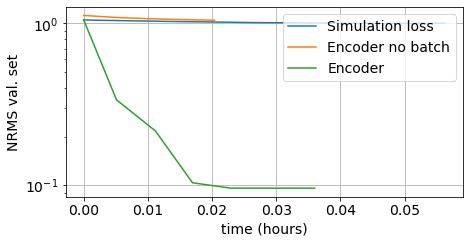

In [16]:
def min_val_array(lis):
    '''Minimum value in to the left'''
    minval = [lis[0]]
    for a in lis[1:]:
        if minval[-1]>a:
            minval.append(a)
        else:
            minval.append(minval[-1])
    return np.array(minval)

plt.figure(figsize=(9*0.75,6*0.6))

plt.plot(sys_no_encode.time/60/60,min_val_array(sys_no_encode.Loss_val),label='Simulation loss')
plt.plot(sys_no_batch.time/60/60,min_val_array(sys_no_batch.Loss_val),label='Encoder no batch')
plt.plot(sys.time/60/60,min_val_array(sys.Loss_val),label='Encoder')

plt.xlabel('time (hours)')
plt.ylabel('NRMS val. set')
plt.legend(loc='upper right')
plt.semilogy()
plt.grid()
plt.tight_layout()
label = 'time-compare-2'
plt.savefig(figure_folder+f'training-{label}.pdf',dpi=200)
plt.savefig(figure_folder+f'training-{label}.png',dpi=200)
plt.show()

## n-step error

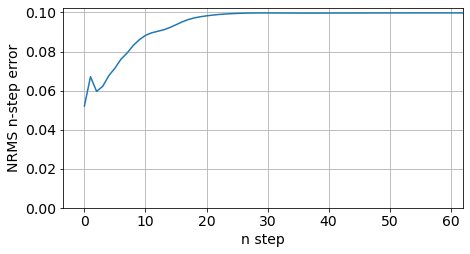

In [18]:
n_step_error = sys.n_step_error(test,nf=70)
plt.figure(figsize=(9*0.75,5*0.75))
plt.plot(n_step_error)
plt.xlabel('n step')
plt.ylabel('NRMS n-step error')
plt.ylim(0,None)
plt.xlim(None,62)
plt.tight_layout()
plt.grid()
plt.savefig(figure_folder+'n-step.pdf')
plt.savefig(figure_folder+'n-step.png',dpi=200)
plt.show()